
#  PHASE 1A, SIRD model to find optimal f values

Here we use the phase1a_betavalues.csv and NYT time series data to find the optimal f values (conditional probability of death given infection) for an SIRD model, this data will be exported as data_bf.csv


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

# Importing our data:

In [2]:
covid19 = pd.read_csv('1A_DATA/us-counties.csv')
pop_data = pd.read_csv('1A_data/phase1_betavalues.csv')

## Defining the SIRD model (gamma = 1/14)

In [3]:
def run_sird(population, b, f, numdays):   

  # values 
  D0 = 0
  I0 = 1
  R0 = 0
  S0 = population - I0 - D0 

  g = 1 / 14

# A grid of time points (in days)
  t = np.linspace(0, numdays, numdays + 1)

  S = S0
  I = I0
  R = R0
  D = D0

  S_list = [S0]
  I_list = [I0]
  R_list = [R0]
  D_list = [D0]

  for time in t[1:]:
      dSdt = (-1.0 * b * S * I)
      dIdt = (b * S * I) - (g * I)
      dDdt = g * f * I
      dRdt = ((1-f) * g * I)
      if (S + dSdt < 0):
            dSdt = -1 * S
            dIdt = S - (g * I)

      S = S + dSdt
      I = I + dIdt
      R = R + dRdt
      D = D + dDdt
      S_list.append(S)
      I_list.append(I)
      R_list.append(R)
      D_list.append(D)
  return S_list, I_list, R_list, D_list

## Defining the objective function

In [4]:
def error_of_sim_2(deaths, D_test):
    original = pd.DataFrame()
    original['deaths'] = deaths
    original['d_test'] = D_test
    return mean_squared_error(original['deaths'], original['d_test'])


#args = (deaths, population, beta)
def objective_fun_2(x, *args):
    S, I, R, D = run_sird(args[1], args[2], x[0], len(args[0]) - 1)
    result = error_of_sim_2(args[0], D)
    return result

## Optimizing each f value for each county using the minimize function as in the last notebook

In [5]:
pop_data["f"] = np.nan
for index, row in pop_data.iterrows(): 
    fips = row['FIPS']
    temp_col = covid19[covid19.fips == fips]
    args = (temp_col['deaths'], row['POPESTIMATE2019'], row['beta'])
    result = minimize(objective_fun_2, [.02], args, method = 'Powell')
    pop_data.loc[pop_data.FIPS == fips, 'f'] = result.x    

Checking a few graphs

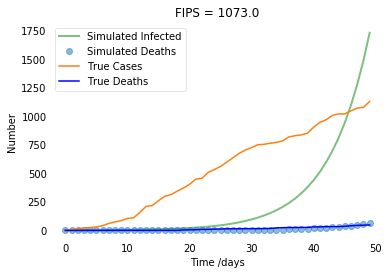

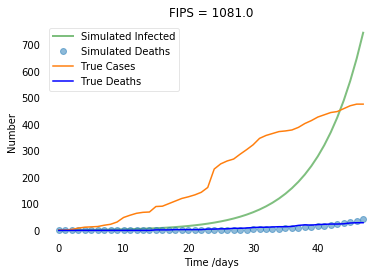

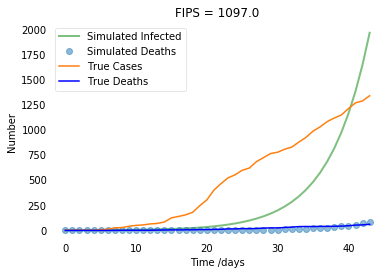

In [6]:
for index, row in pop_data.head(n=3).iterrows():
    temp_col = covid19[covid19.fips == row['FIPS']]
    S, I, R, D = run_sird(row['POPESTIMATE2019'], row["beta"], row["f"], len(temp_col) - 1)
    t = np.linspace(0, len(temp_col)-1, len(temp_col))

    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(t, I, 'g', alpha=0.5, lw=2, label='Simulated Infected')
    ax.plot(t, D, 'o', alpha=0.5, lw=2, label='Simulated Deaths')


    ax.plot(t, temp_col['cases'] * (100/82.1), label = 'True Cases')
    ax.plot(t, temp_col['deaths'], 'b', label = 'True Deaths')
    ax.set_title("FIPS = " + str(row['FIPS']))

    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

##  EXPORT:

In [9]:
pop_data.to_csv('1A_DATA/data_bf.csv')